Initializing libraries

In [43]:
#Data manipulation libraries
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import glob
import csv
from pandas import Series, DataFrame
import pandas as pd
import numpy as np
import math

#Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
%pylab inline

#Preprocessing libraries
import sklearn
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

#ML libraries
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from statsmodels.tsa import stattools
from sklearn.svm import SVC
from sklearn.cluster import KMeans

#Metrics libraries
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, accuracy_score
from sklearn.metrics import f1_score
from scipy.stats import skew, kurtosis

Populating the interactive namespace from numpy and matplotlib


Importing data

Given that there is a csv file for every user, let's start with combining all the csv files to form a single csv file. The columns in the combined csv will be: timestamp, acceleration in x axis, y axis and z axis and user_id label.

PS: The above approach has been chosen given there are only 22 users. With upto 1000 users and about few 1000 rows per user, I may choose to have a combined csv and read into pandas using chunking. For millions of users, I may choose to sample some users instead or use cloud compute to accommodate larger scale.

In [44]:
path = r'ViaductDataset' 
all_files = glob.glob(path + "/*.csv")
col_list = ['timeStamp','xAxisAcc','yAxisAcc','zAxisAcc']
temp_list = []
counter=1
for filename in all_files:
    temp_df = pd.read_csv(filename,header=None,names=col_list)
    temp_df['user_id']=counter
    temp_list.append(temp_df)
    counter+=1
df = pd.concat(temp_list, axis=0, ignore_index=True)

In [45]:
df.head()

,timeStamp,xAxisAcc,yAxisAcc,zAxisAcc,user_id
0,0.000000,0.69464,3.17350,7.5048,1
1,0.030639,0.14982,3.48680,9.2755,1
2,0.069763,-0.29965,1.94770,9.1120,1
3,0.099823,-1.68890,1.41650,10.1200,1
4,0.129820,-2.17930,0.95342,10.9240,1


Summary statistics on data

Now that we have the dataframe, let's do some summary statistics on the dataset:
1. Number of rows and columns
2. Type of each column
3. Presence/absence of missing values: From the results, we can see that there are no missing values

In [46]:
df.shape

(151773, 5)

In [47]:
df.dtypes

timeStamp    float64
xAxisAcc     float64
yAxisAcc     float64
zAxisAcc     float64
user_id        int64
dtype: object

In [48]:
df.isnull().sum()/len(df)

timeStamp    0.0
xAxisAcc     0.0
yAxisAcc     0.0
zAxisAcc     0.0
user_id      0.0
dtype: float64

Data Analysis

In [49]:
df['user_id'].value_counts().sort_values(ascending=True)

11      911
18     1129
16     1144
8      1728
23     2441
14     3082
2      3086
21     3457
7      3653
20     3729
12     3882
4      4799
19     4936
1      5069
3      5636
5      6699
17     6981
22     7988
15     9698
6     12027
13    16949
10    20758
9     21991
Name: user_id, dtype: int64

From the table above, we can see that there are users with data collected over limited time. Casale's paper on this area suggests that data has been collected at a frequency of 33 ms. 

1818 data points are required to get atleast data over a minute when frequency is 33ms. So I am removing user ids 11, 18, 16, 8 since the data is too less for any meaningful analysis.

In [50]:
remove_list=[11,18,16,8]
df=df[~df['user_id'].isin(remove_list)]

In [51]:
def showPlots(x,y,z):
    fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, sharey=True, figsize=(20,10))
    ax  = fig.add_subplot(111)

    ax1_df=df[df['user_id']==x]
    ax1 = fig.add_subplot(311)
    ax1.plot(ax1_df['timeStamp'],ax1_df['xAxisAcc'], label='xAxis Acceleration')
    ax1.plot(ax1_df['timeStamp'],ax1_df['yAxisAcc'], label='yAxis Acceleration')
    ax1.plot(ax1_df['timeStamp'],ax1_df['zAxisAcc'], label='zAxis Acceleration')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    ax2_df=df[df['user_id']==y]
    ax2 = fig.add_subplot(312)
    ax2.plot(ax2_df['timeStamp'],ax2_df['xAxisAcc'])
    ax2.plot(ax2_df['timeStamp'],ax2_df['yAxisAcc'])
    ax2.plot(ax2_df['timeStamp'],ax2_df['zAxisAcc'])

    ax3_df=df[df['user_id']==z]
    ax3 = fig.add_subplot(313)
    ax3.plot(ax3_df['timeStamp'],ax3_df['xAxisAcc'])
    ax3.plot(ax3_df['timeStamp'],ax3_df['yAxisAcc'])
    ax3.plot(ax3_df['timeStamp'],ax3_df['zAxisAcc'])

    ax.set_xlabel('TimeStamp')
    ax.set_ylabel('Acceleration in x,y,z axes')
    plt.show()

Below, we have shown what the acceleration in x,y,z axes looks like for user_ids 1,2,3. From the figure, we see that the acceleration in the y axis is the highest, followed by  z axis and x axis. It is also clear that different users seem to have different walking styles. So, individual walking styles could be a good predictor to identify the user.

It also looks like removing the first 10-20 and last 10-20 time periods might be a good idea, since the data seems to be tailing off at both ends.

I am also interested in the level of correlation between acceleration in x,y,z axes. Below values are for user_id=1 and shows some amount of correlation (on average between 0.25 and 0.45 for all user_ids)

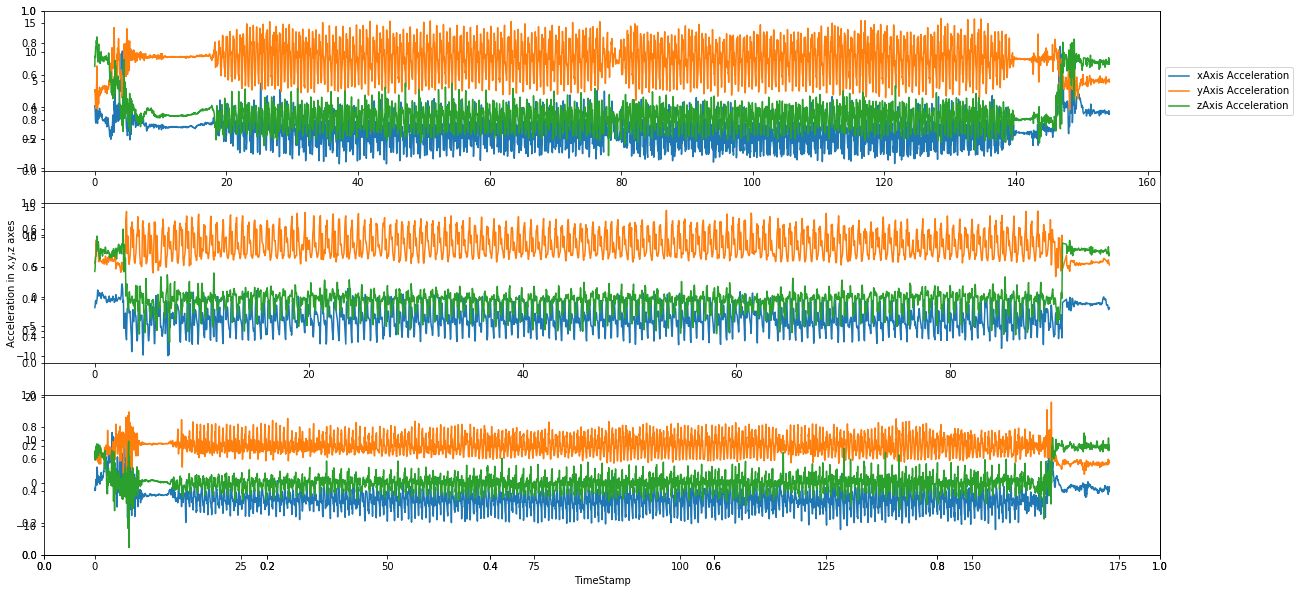

In [52]:
showPlots(1,2,3)

In [53]:
df[df['user_id']==1][['xAxisAcc','yAxisAcc','zAxisAcc']].corr()

,xAxisAcc,yAxisAcc,zAxisAcc
xAxisAcc,1.000000,-0.360648,0.392433
yAxisAcc,-0.360648,1.000000,-0.450373
zAxisAcc,0.392433,-0.450373,1.000000


In [54]:
#Removing first 20 and last 20 time periods for each user_id
user_list=df['user_id'].unique().tolist()
temp_list=[]
for i in user_list:
    temp_df=df[df['user_id']==i]
    temp_min=temp_df['timeStamp'].min()+20
    temp_max=temp_df['timeStamp'].max()-20
    temp_list.append(temp_df[(temp_df['timeStamp']>temp_min) & (temp_df['timeStamp']<temp_max)])
df=pd.concat(temp_list, axis=0, ignore_index=True)   

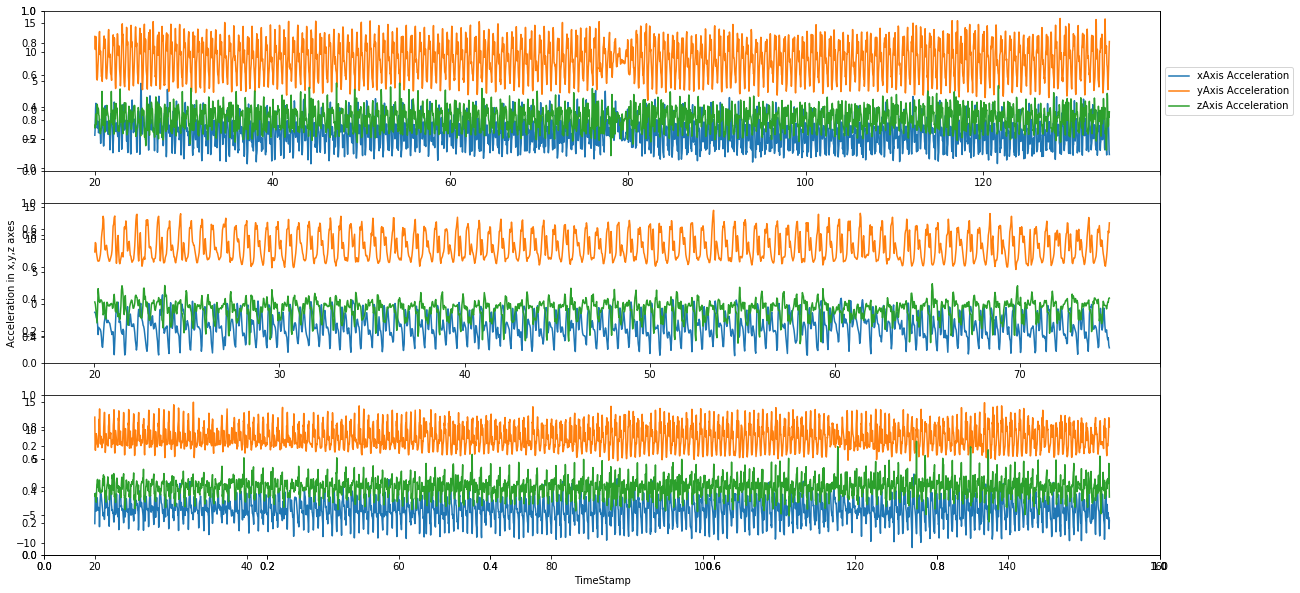

In [55]:
showPlots(1,2,3)

Feature Engineering

I have looked at some of the feature engineering steps followed for similar problems and utilized them below as:
1. Build windows of 100 data points from the total dataset for each user
2. Create new features for each window such as mean, standard deviation, autocorrelation, skew and kurtosis
(I have not considered features which might be highly related to the ones mentioned above such as variance or autocovariance)

I plan to use the windowed data with the features mentioned above and use feature selection so that the unimportant features can be dropped.

In [56]:
#Function for defining the window on data
def window(axis,dx=100):
    start = 0;
    size = axis.count();

    while (start < size):
        end = start + dx
        yield start,end
        start = start+int (dx/2)
        
#Features which are extracted from Raw sensor data
def window_summary(axis, start, end):
    acf = stattools.acf(axis[start:end])
    return [
        axis[start:end].mean(),
        axis[start:end].std(),
        axis[start:end].min(),
        axis[start:end].max(),
        acf.mean(), 
        acf.std(), 
        skew(axis[start:end]),
        kurtosis(axis[start:end])
    ]

def features(user_id):
    for (start, end) in window(user_id['timeStamp']):
        features = []
        for axis in ['xAxisAcc', 'yAxisAcc', 'zAxisAcc']:
            features += window_summary(user_id[axis], start, end)
        yield features

In [57]:
with open('ViaductDataset/Features.csv', 'w') as out:
    rows = csv.writer(out)
    for i in user_list:
        for j in features(df[df['user_id']==i]):
            rows.writerow([i]+j)    

In [58]:
col_list = ['user_id','xAxisAccMean','xAxisAccStd','xAxisAccMin','xAxisAccMax','xAxisAccAcfMean',\
                       'xAxisAccAcfStd','xAxisAccSkew','xAxisAccKurtosis',\
                       'yAxisAccMean','yAxisAccStd','yAxisAccMin','yAxisAccMax','yAxisAccAcfMean',\
                       'yAxisAccAcfStd','yAxisAccSkew','yAxisAccKurtosis',\
                       'zAxisAccMean','zAxisAccStd','zAxisAccMin','zAxisAccMax','zAxisAccAcfMean',\
                       'zAxisAccAcfStd','zAxisAccSkew','zAxisAccKurtosis']

In [59]:
df=pd.read_csv('ViaductDataset/Features.csv',header=None,names=col_list)

In [60]:
df.head()

,user_id,xAxisAccMean,xAxisAccStd,xAxisAccMin,xAxisAccMax,xAxisAccAcfMean,xAxisAccAcfStd,xAxisAccSkew,xAxisAccKurtosis,yAxisAccMean,...,yAxisAccSkew,yAxisAccKurtosis,zAxisAccMean,zAxisAccStd,zAxisAccMin,zAxisAccMax,zAxisAccAcfMean,zAxisAccAcfStd,zAxisAccSkew,zAxisAccKurtosis
0,1,-2.979727,1.864506,-7.4367,1.3348,0.023464,0.301109,-0.017981,-0.125469,9.008242,...,-0.091955,-1.258930,-1.544959,1.715508,-4.3313,3.5958,0.029430,0.312768,0.559230,0.086865
1,1,-3.086369,2.195705,-7.6546,1.6889,0.008696,0.323781,-0.131981,-0.404165,9.063522,...,-0.100414,-1.255516,-1.439805,1.718632,-4.3313,3.5958,0.026266,0.328706,0.273291,-0.325109
2,1,-2.697099,2.460727,-7.6955,4.5628,0.023309,0.332978,0.122357,0.378214,9.179602,...,-0.120536,-1.283864,-1.737139,1.786791,-6.2109,2.1520,0.042167,0.310540,-0.144766,-0.680294
3,1,-2.584054,2.394060,-7.6955,4.5628,0.007840,0.342619,0.294587,0.636469,9.198539,...,-0.143971,-1.255235,-1.824174,1.966208,-6.2109,2.2201,0.037617,0.300561,0.008030,-0.929356
4,1,-3.059130,2.360653,-8.1177,3.5277,0.012724,0.339746,0.210239,0.100851,9.106566,...,-0.143210,-1.304321,-1.679933,1.922113,-5.2030,2.2201,0.019881,0.295685,-0.013083,-1.137365


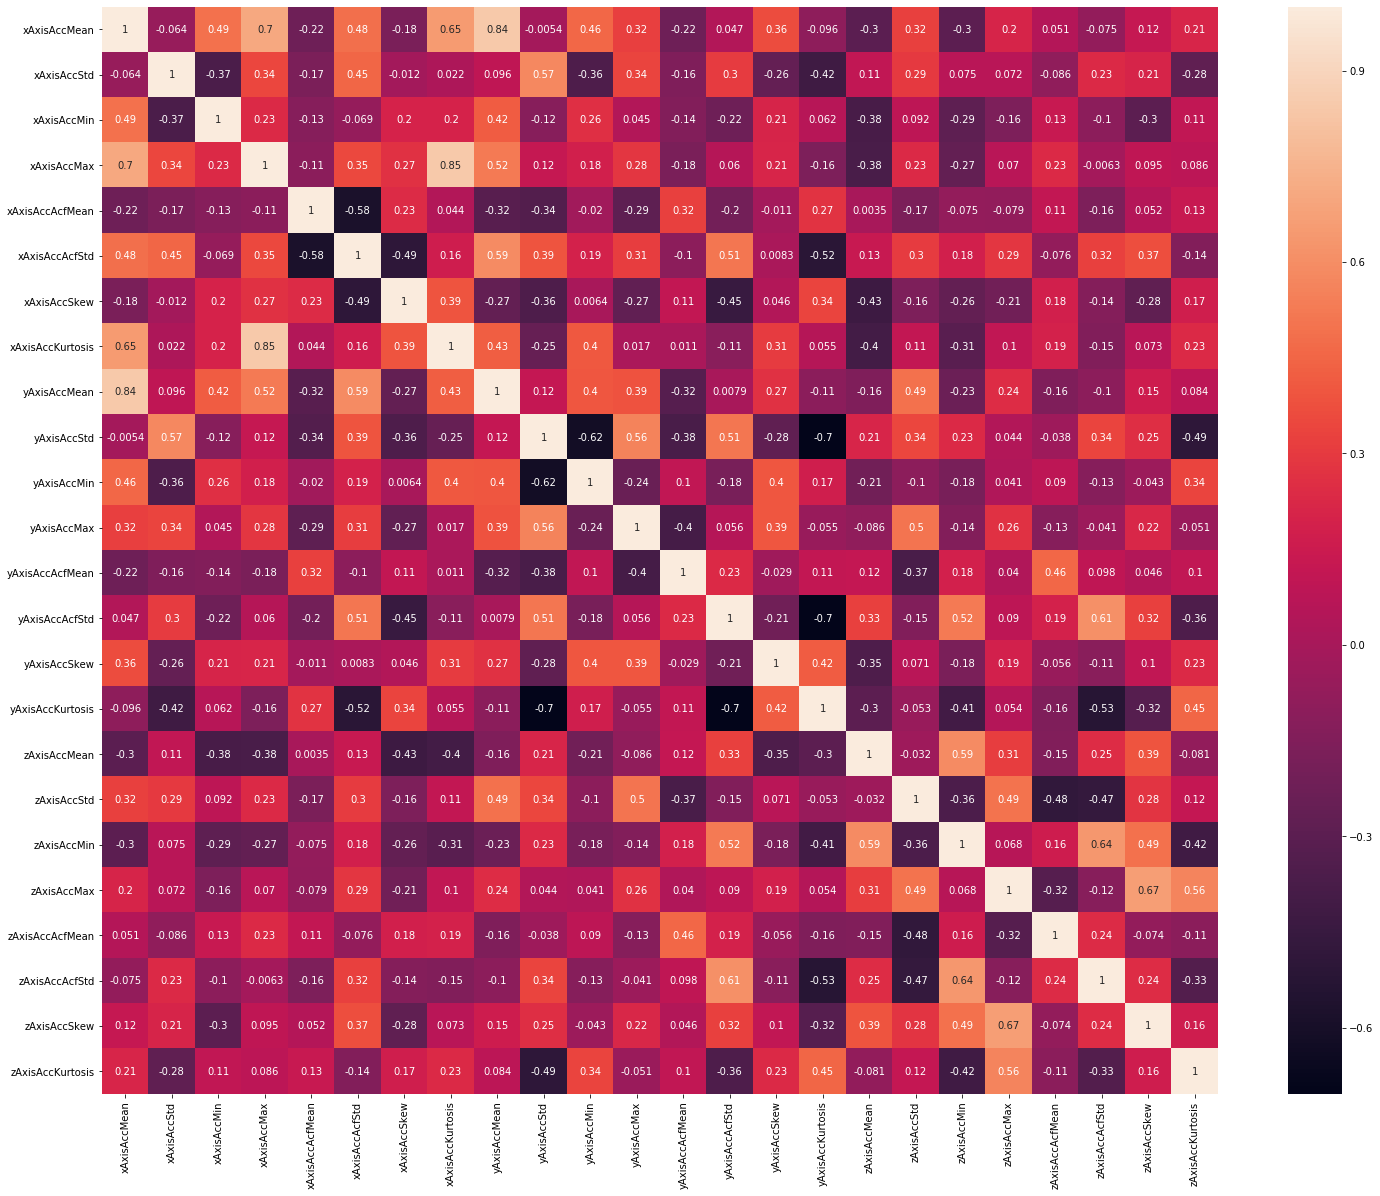

In [61]:
plt.figure(figsize=(25,20))
sns.heatmap(df[df['user_id']==1].iloc[:,1:].corr(),annot=True)
plt.show()

From the plot above, we can see that there are cases where the correlation between the features is above 0.7. These might be good candidates to remove from the overall feature set, in the feature selection process.

Modelling

With respect to the dataset, I am considering two types of ML techniques:
1. Classification: Identify the user based on the walking styles. Given that the feature set includes 33 features, some of them highly correlated, the plan is to use feature selection, followed by a set of classifiers: Logistic Regression, SVM, Decision Tree, Random Forest.

Using GAIT data for identification can be utilized as a method of authentication, similar to face or fingerprint.For example, in manufacturing plants, this could possibly be utilized for attendance management and monitoring of contractual labour force.

2. Clustering: I am interested in also analyzing if there are similarities in walking styles amongst people, which groups them in the same cluster.

For example, in healthcare, this could help in streamlining  first level medical intervention for each person based on the cluster. 

Data pre processing


Steps followed:

1.Split the data into train and test dataset

2.Label encode the Y variable: user_id

3.Use min max scaler to scale the numeric features


In [62]:
#Utilizing stratify paramater so that class distribution is maintained in the split
X=df.drop(['user_id'],axis=1)
Y=df['user_id']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y)

In [63]:
le = LabelEncoder()
Y_train=le.fit_transform(Y_train)
Y_test=le.transform(Y_test)

In [64]:
numeric_transformer = Pipeline(steps=[('scaler', MinMaxScaler())])
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
preprocessor = ColumnTransformer(transformers=[ ('num', numeric_transformer, numeric_features)])

Model building

Given it is a classification task, below is the process followed:
1. Utilized feature selection through L1 regularization/feature importance
2. Logistic Regression, KNN, SVC, Decision Tree and Random Forest are the classifiers used
3. Used GridSearchCV for tuning hyperparameters and finding the best hyper parameters, which give the lowest error on validation dataset


Logistic Regression

In [65]:
#C is the regularization strength and is the hyperparameter here
lr = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression(penalty='l1'))])
params = { 
    'classifier__C': [10,1,0.1,0.001]}
lr_gs= GridSearchCV(lr, param_grid=params,cv=5)
lr_gs.fit(X_train, Y_train)
print(lr_gs.best_params_)
print(abs(lr_gs.best_score_))

{'classifier__C': 10}
0.7556352459016393


KNN Classifier

In [66]:
knn = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', KNeighborsClassifier())])
params = { 
    'classifier__n_neighbors': [10,20,50,100,200]}
knn_gs = GridSearchCV(knn, param_grid=params,cv=5)
knn_gs.fit(X_train, Y_train)  
print(knn_gs.best_params_)
print(abs(knn_gs.best_score_))

{'classifier__n_neighbors': 10}
0.8340163934426229


SVC

In [67]:
svc = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', SVC())])

params = { 
    'classifier__kernel': ['linear','poly','rbf','sigmoid'],
    'classifier__C': [0.1,1,5,10]   
}
svc_gs = GridSearchCV(svc, param_grid=params,cv=5)
svc_gs.fit(X_train, Y_train)
print(svc_gs.best_params_)
print(abs(svc_gs.best_score_))

{'classifier__C': 10, 'classifier__kernel': 'linear'}
0.8099385245901639


Decision Tree

In [68]:
dt = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', DecisionTreeClassifier())])

params = { 
    'classifier__max_depth' : [4,6,8],
    'classifier__max_features' : [4,6,8],
    'classifier__criterion' : ['gini','entropy']
}
dt_gs = GridSearchCV(dt, param_grid=params,cv=5)
dt_gs.fit(X_train, Y_train)
print(dt_gs.best_params_)
print(abs(dt_gs.best_score_))

{'classifier__criterion': 'entropy', 'classifier__max_depth': 8, 'classifier__max_features': 8}
0.7704918032786885


Random Forest

In [69]:
rf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier())])
params = { 
    'classifier__n_estimators': [100,200,400],
    'classifier__max_depth' : [6,8,10],
    'classifier__max_features' : [6,8,10],
    'classifier__criterion' : ['gini','entropy']
}
rf_gs = GridSearchCV(rf, param_grid=params,cv=5)
rf_gs.fit(X_train, Y_train)
print(rf_gs.best_params_)
print(abs(rf_gs.best_score_))

{'classifier__criterion': 'entropy', 'classifier__max_depth': 10, 'classifier__max_features': 6, 'classifier__n_estimators': 400}
0.9098360655737705


Model Interpretation

In this phase, we are utilizing the tuned model with the best performance in each classifier, to predict on the test data set. The metrics of evaluation that have been used are F1-score and misclassification rate. F1-score seems to suit as a good metric since both precision and recall are important here and therefore, a combined metric seems to make sense.

We find the tuned random forest model performs best on the test dataset.

Logistic Regression

In [70]:
final_lr = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression(C=10,penalty='l1'))])
final_lr.fit(X_train,Y_train)
Y_pred=final_lr.predict(X_test)
Y_pred_ = final_lr.predict_proba(X_test)
print("F1 score is",f1_score(Y_test, Y_pred, average='weighted')) 
print('Misclassified samples for selected model: %d' %(Y_test != Y_pred).sum())

F1 score is 0.7620799002196189
Misclassified samples for selected model: 108


KNN Classifier

In [31]:
final_knn = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', KNeighborsClassifier(n_neighbors=10))])
final_knn.fit(X_train,Y_train)
Y_pred=final_knn.predict(X_test)
print("F1 score is",f1_score(Y_test, Y_pred, average='weighted')) 
print('Misclassified samples for selected model: %d' %(Y_test != Y_pred).sum())

F1 score is 0.7918249274646753
Misclassified samples for selected model: 97


SVM

In [71]:
final_svc = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', SVC(kernel='linear',C=10))])
final_svc.fit(X_train,Y_train)
Y_pred=final_svc.predict(X_test)
print("F1 score is",f1_score(Y_test, Y_pred, average='weighted')) 
print('Misclassified samples for selected model: %d' %(Y_test != Y_pred).sum())

F1 score is 0.8335882038922289
Misclassified samples for selected model: 78


Decision Tree

In [72]:
final_dt = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', DecisionTreeClassifier(criterion='entropy',max_depth=8,max_features=8))])
final_dt.fit(X_train,Y_train)
Y_pred=final_dt.predict(X_test)
print("F1 score is",f1_score(Y_test, Y_pred, average='weighted')) 
print('Misclassified samples for selected model: %d' %(Y_test != Y_pred).sum())

F1 score is 0.8053639229313257
Misclassified samples for selected model: 96


Random Forest

In [73]:
final_rf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier(criterion='entropy',n_estimators=100,max_depth=8,max_features=6))])
final_rf.fit(X_train,Y_train)
Y_pred=final_rf.predict(X_test)
print("F1 score is",f1_score(Y_test, Y_pred, average='weighted')) 
print('Misclassified samples for selected model: %d' %(Y_test != Y_pred).sum())

F1 score is 0.9162445801639971
Misclassified samples for selected model: 40


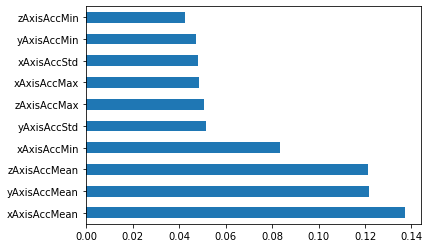

In [74]:
feat_importances = pd.Series(final_rf.named_steps['classifier'].feature_importances_, index=df.columns[1:])
feat_importances.sort_values(ascending=False)[:10].plot(kind='barh')

From the feature importance plots, it is clear that the most important features are the mean acceleration values in x,y,z axes, followed by min,max and standard deviation values in the axes.

Clustering

It might be interesting to understand if the users can be classified into different clusters based on their walking styles. If mapped to health related data, this could also be helpful in determining patterns which are common within a cluster.

In [75]:
df_cluster=df.groupby(['user_id'])[['xAxisAccMean','yAxisAccMean','zAxisAccMean']].mean()

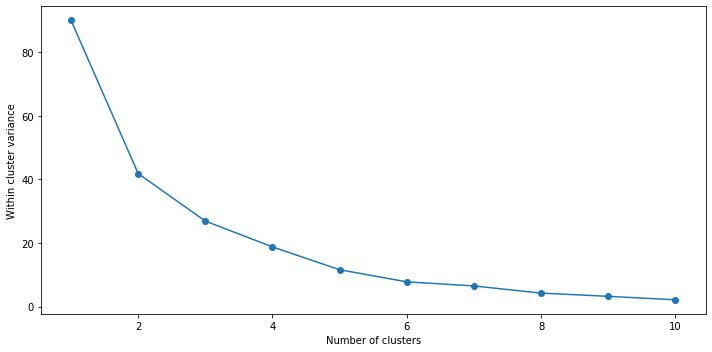

In [76]:
distortions = []
for i in range(1, 11):
    km = KMeans(n_clusters=i, 
                init='k-means++', 
                n_init=10, 
                max_iter=300, 
                random_state=0)
    km.fit(df_cluster)
    distortions.append(km.inertia_)
plt.figure(figsize=(10,5))
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Within cluster variance')
plt.tight_layout()
plt.show()

The elbow plot has been used to determine the appropriate number of clusters for the users in the data. It doesn't seem like the elbow plot is given a clera result, so I tried 2 or 3 clusters and found 2 clusters to be better.

In [77]:
km = KMeans(n_clusters=2, random_state=1)
y_km=km.fit_predict(df_cluster)
#Finding cluster labels and adding it to the dataframe
labels=km.labels_.tolist()
df_cluster['labels'] = pd.Series(labels, index=df_cluster.index)

In [78]:
#Cluster centers
km.cluster_centers_

array([[-0.03702273,  9.37148337,  0.46172507],
       [-3.16041525,  8.66091417, -0.2029877 ]])

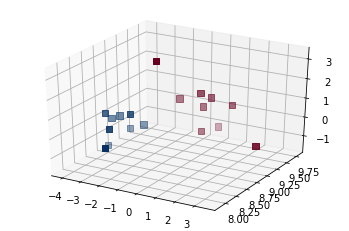

In [79]:
#Plotting the data points corresponding to each cluster in a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = np.array(df_cluster['xAxisAccMean'])
y = np.array(df_cluster['yAxisAccMean'])
z = np.array(df_cluster['zAxisAccMean'])
ax.scatter(x,y,z, marker="s", c=df_cluster["labels"], s=40, cmap="RdBu")
plt.show()

From the above clusters, we see that the the primary difference in walking styles between people is caused  by acceleration values in x and z axes, while y axis acceleration is about the same.

For the data we obtained, we get 2 clusters:

Cluster 1 with very low negative x axis acceleration, high positive y axis accleration, low positive z axis accleration

Cluster 2 with mid negative x axis acceleration, high positive y axis acceleration, low negative z axis acceleration
